# City of Baltimore crime data - Analysis to compare the neighbourhoods with highest & lowest crimes

## 1. Import City of Baltimore crime data

#### Install all required libraries

In [1]:
!pip install folium
!pip install geopy

     |████████████████████████████████| 112kB 3.7MB/s eta 0:00:01


#### import all libraries

In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np

#### Read table from csv uisng pandas

In [3]:
#def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
#client_6f9e6dffb61f47b5aececa14f0fd563b = ibm_boto3.client(service_name='s3',
#    ibm_api_key_id='2xP2dfjHVUoyd474ms0gD9svBDnUKnb2pLUxgDvattKq',
#    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
#    config=Config(signature_version='oauth'),
#    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

#body = client_6f9e6dffb61f47b5aececa14f0fd563b.get_object(Bucket='kickstartdatascience-donotdelete-pr-s95tt1ehpuhauy',Key='BPD_Part_1_Victim_Based_Crime_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

#Read CSV
df_cd = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv')#(body)

#Print shape & head
print(df_cd.shape)
df_cd.head()

(285807, 12)


,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Total Incidents
0,11/12/2016,02:35:00,3B,300 SAINT PAUL PL,ROBBERY - STREET,O,NaN,111.0,CENTRAL,Downtown,"(39.2924100000, -76.6140800000)",1
1,11/12/2016,02:56:00,3CF,800 S BROADWAY,ROBBERY - COMMERCIAL,I,FIREARM,213.0,SOUTHEASTERN,Fells Point,"(39.2824200000, -76.5928800000)",1
2,11/12/2016,03:00:00,6D,1500 PENTWOOD RD,LARCENY FROM AUTO,O,NaN,413.0,NORTHEASTERN,Stonewood-Pentwood-Winston,"(39.3480500000, -76.5883400000)",1
3,11/12/2016,03:00:00,6D,6600 MILTON LN,LARCENY FROM AUTO,O,NaN,424.0,NORTHEASTERN,Westfield,"(39.3626300000, -76.5516100000)",1
4,11/12/2016,03:00:00,6E,300 W BALTIMORE ST,LARCENY,O,NaN,111.0,CENTRAL,Downtown,"(39.2893800000, -76.6197100000)",1


# 2. Clean Data

In [4]:
df_cd['CrimeDate'] = pd.to_datetime(df_cd['CrimeDate'])
df_cd[['Latitude','Longitude']] = df_cd['Location 1'].str.replace(repl='',pat='(').str.replace(repl='',pat=')').str.split(',',expand=True)
#df_cd['Longitude'] = df_cd['Location 1'].str.replace(repl='',pat='(').str.replace(repl='',pat=')').str.split(',')[0][1]
df_cd.drop(columns=['CrimeCode','Location','Inside/Outside','Weapon','Post','District','Location 1','Total Incidents'], axis=1,inplace = True)
df_cd = df_cd.astype({'Description':str,'Neighborhood':str,'Latitude':float,'Longitude':float})
df_cd = df_cd.replace('nan',np.nan).dropna()
print(df_cd.dtypes)
df_cd.head()

CrimeDate       datetime64[ns]
CrimeTime               object
Description             object
Neighborhood            object
Latitude               float64
Longitude              float64
dtype: object


,CrimeDate,CrimeTime,Description,Neighborhood,Latitude,Longitude
0,2016-11-12,02:35:00,ROBBERY - STREET,Downtown,39.29241,-76.61408
1,2016-11-12,02:56:00,ROBBERY - COMMERCIAL,Fells Point,39.28242,-76.59288
2,2016-11-12,03:00:00,LARCENY FROM AUTO,Stonewood-Pentwood-Winston,39.34805,-76.58834
3,2016-11-12,03:00:00,LARCENY FROM AUTO,Westfield,39.36263,-76.55161
4,2016-11-12,03:00:00,LARCENY,Downtown,39.28938,-76.61971


In [5]:
#Retain only the specified crime in all neighbourhoods
crime = 'ROBBERY - STREET'
df_crime = df_cd[df_cd['Description'] == crime].reset_index()
df_crime['Neighborhood'].value_counts()

Downtown                           882
Frankford                          421
Belair-Edison                      321
Patterson Park Neighborhood        306
Coldstream Homestead Montebello    254
                                  ... 
The Orchards                         1
Mt Pleasant Park                     1
Bellona-Gittings                     1
Blythewood                           1
Spring Garden Industrial Area        1
Name: Neighborhood, Length: 274, dtype: int64

In [6]:
#Create a datframe with neighborhoods and location
df_neighborhoods = df_crime[['Neighborhood','Latitude','Longitude']].groupby('Neighborhood').mean()
df_neighborhoods = df_neighborhoods.join(df_crime[['Neighborhood','Description']].groupby('Neighborhood').count(),on='Neighborhood')
df_neighborhoods.rename(columns={'Description':'CrimeCount'},inplace=True)
df_neighborhoods.reset_index(inplace=True)
df_neighborhoods.head()

,Neighborhood,Latitude,Longitude,CrimeCount
0,Abell,39.325983,-76.610579,61
1,Allendale,39.290566,-76.679956,57
2,Arcadia,39.332928,-76.569111,13
3,Arlington,39.348357,-76.680987,75
4,Armistead Gardens,39.470197,-76.549902,28


# 3. Visualization

#### Import necessary libraries

In [7]:
import json
import requests
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Crimes - yearwise split

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

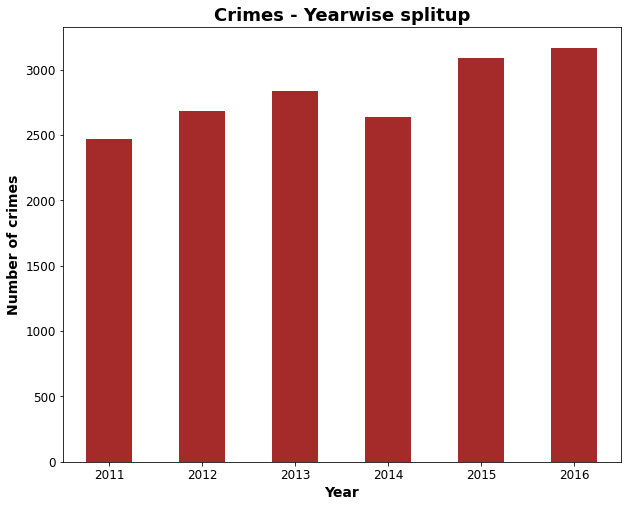

In [8]:
df_yearwise = pd.DataFrame(columns=['Year','Number Of Crimes'])
df_yearwise['Year'] = df_crime['CrimeDate'].dt.year
df_yearwise['Number Of Crimes'] = 1
df_yearwise = df_yearwise.groupby('Year').count()

df_yearwise.plot(kind='bar',color='brown',figsize=(10,8),legend=None)
plt.title('Crimes - Yearwise splitup',fontsize=18,fontweight='bold')
plt.xlabel('Year',fontsize=14,fontweight='bold')
plt.ylabel('Number of crimes',fontsize=14,fontweight='bold')
plt.xticks(rotation=0,fontsize=12)
plt.yticks(fontsize=12)

#### Crimes - monthwise split

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

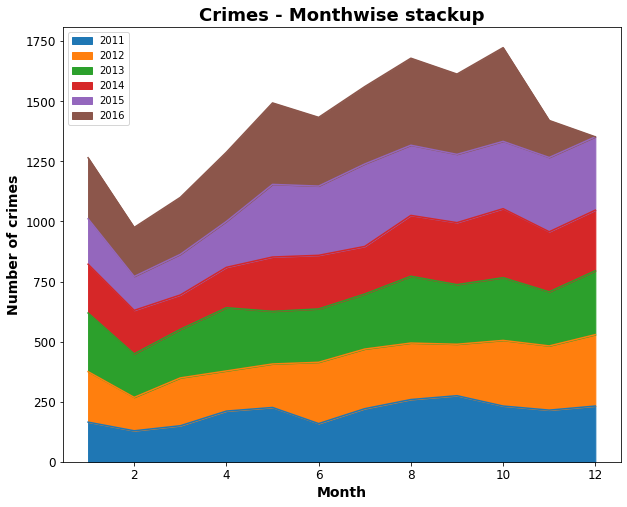

In [9]:
df_monthwise = pd.DataFrame(columns=['Month','Year'])
df_monthwise['Month'] = df_crime['CrimeDate'].dt.month
df_monthwise['Year'] = df_crime['CrimeDate'].dt.year
df_monthwise = df_monthwise[['Month']].join(pd.get_dummies(df_monthwise['Year']))
df_monthwise = df_monthwise.groupby('Month').sum()
#df_monthwise = df_monthwise.reset_index(drop=True)
df_monthwise
df_monthwise.plot(kind='area',figsize=(10,8))
plt.title('Crimes - Monthwise stackup',fontsize=18,fontweight='bold')
plt.xlabel("Month",fontsize=14,fontweight='bold')
plt.ylabel("Number of crimes",fontsize=14,fontweight='bold')
plt.xticks(rotation=0,fontsize=12)
plt.yticks(fontsize=12)

#### Crimes - time of the day

[3971 1863 4308 6760] [ 0  6 12 18 24]


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

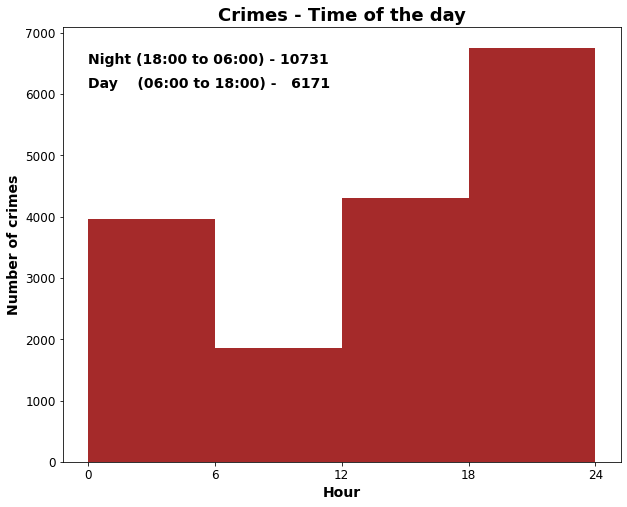

In [10]:
df_crimetime = pd.DataFrame(columns=['hour'])
df_crimetime[['hour']] = df_crime['CrimeTime'].str.split(':',expand=True).iloc[:,:1]
df_crimetime = df_crimetime[['hour']].astype(int)

bins_list=[0,6,12,18,24]
count,bins = np.histogram(df_crimetime['hour'],bins_list)
print(count,bins)

df_crimetime['hour'].plot(kind='hist',bins=bins_list,xticks=bins_list,color='brown',figsize=(10,8))
plt.xlabel('Hour',fontsize=14,fontweight='bold')
plt.ylabel('Number of crimes',fontsize=14,fontweight='bold')
plt.title('Crimes - Time of the day',fontsize=18,fontweight='bold')
plt.annotate("Night (18:00 to 06:00) - {}".format(count[0] + count[3]),xy=(0,6500),fontsize=14,fontweight='bold')
plt.annotate("Day    (06:00 to 18:00) -   {}".format(count[1] + count[2]),xy=(0,6100),fontsize=14,fontweight='bold')
plt.xticks(rotation=0,fontsize=12)
plt.yticks(fontsize=12)

#### Show all the neighbourhoods on the Baltimore map

In [11]:
# create map of Baltimore using latitude and longitude values
map_baltimore = folium.Map(location=[df_neighborhoods['Latitude'].mean(), df_neighborhoods['Longitude'].mean()], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df_neighborhoods['Latitude'], df_neighborhoods['Longitude'], df_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_baltimore)  
    
map_baltimore

#### Collect neighborhoods with most & least crimes

In [12]:
nCritical = 25
df_topmost = df_neighborhoods.sort_values('CrimeCount',ascending=False).iloc[:nCritical,:]
df_botmost = df_neighborhoods.sort_values('CrimeCount').iloc[:nCritical,:]
print(df_topmost.head(),df_botmost.head())

                        Neighborhood   Latitude  Longitude  CrimeCount
62                          Downtown  39.290668 -76.616339         882
85                         Frankford  39.327254 -76.546381         421
11                     Belair-Edison  39.327834 -76.568954         321
194      Patterson Park Neighborhood  39.300363 -76.574490         306
50   Coldstream Homestead Montebello  39.323335 -76.593803         254                    Neighborhood  Latitude  Longitude  CrimeCount
19                   Blythewood  39.34974  -76.62291           1
237                The Orchards  39.36232  -76.62501           1
56   Curtis Bay Industrial Area  39.22685  -76.58694           1
161                 Morgan Park  39.34529  -76.57812           1
59                  Dickeyville  39.31072  -76.70824           1


#### Show only the top & bottom most neighborhoods on map

In [13]:
# create map of Baltimore using latitude and longitude values
map_baltimore = folium.Map(location=[df_neighborhoods['Latitude'].mean(), df_neighborhoods['Longitude'].mean()], zoom_start=12)

# add markers to map for topmost
for lat, lng, neighborhood,CrimeCount in zip(df_topmost['Latitude'], df_topmost['Longitude'], df_topmost['Neighborhood'], df_topmost['CrimeCount']):
    label = '{} ({} crimes)'.format(neighborhood,CrimeCount)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_baltimore)  
    
# add markers to map for bottom most
for lat, lng, neighborhood,CrimeCount in zip(df_botmost['Latitude'], df_botmost['Longitude'], df_botmost['Neighborhood'], df_botmost['CrimeCount']):
    label = '{} ({} crimes)'.format(neighborhood,CrimeCount)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_baltimore) 
    
map_baltimore

#### Foursquare credentials

In [14]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20201231' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Function to get all the nearby venues of a position

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,'police')
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get all the near by venues for all the neighborhoods

In [16]:
neighborhood_venues = getNearbyVenues(df_neighborhoods['Neighborhood'],
                                  df_neighborhoods['Latitude'],
                                  df_neighborhoods['Longitude'])
neighborhood_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abell,39.325983,-76.610579,32nd Street Farmer's Market,39.327362,-76.610851,Farmers Market
1,Abell,39.325983,-76.610579,Pete's Grille,39.327064,-76.609593,Breakfast Spot
2,Abell,39.325983,-76.610579,The Book Thing,39.325253,-76.610272,Bookstore
3,Abell,39.325983,-76.610579,Peabody Heights Brewery,39.324744,-76.610819,Brewery
4,Abell,39.325983,-76.610579,Melba's Place,39.326926,-76.609905,Bar


#### Analyze neighborhood

In [17]:
topbot_list = list(df_topmost['Neighborhood']) + list(df_botmost['Neighborhood'])
venues_categories = pd.get_dummies(neighborhood_venues[neighborhood_venues['Neighborhood'].isin(topbot_list)][['Venue Category']], prefix="", prefix_sep="")

#Pick top categories
ntop = 10
top_categories = venues_categories.sum().sort_values(ascending=False).head(ntop)

# add neighborhood column back to dataframe
venues_categories['Neighborhood'] = neighborhood_venues[neighborhood_venues['Neighborhood'].isin(topbot_list)]['Neighborhood']

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + list(top_categories.index.values) # list(venues_categories.columns[:-1])
venues_categories = venues_categories[fixed_columns]

venues_categories.head()

,Neighborhood,Bar,Pizza Place,Sandwich Place,Coffee Shop,Convenience Store,Theater,Café,Liquor Store,Park,Chinese Restaurant
54,Baltimore Highlands,0,0,0,0,0,0,0,0,0,0
55,Baltimore Highlands,0,0,0,0,0,0,0,0,0,0
56,Baltimore Highlands,0,0,0,0,0,0,0,0,0,0
57,Baltimore Highlands,0,0,0,0,0,0,0,0,0,0
58,Baltimore Highlands,0,0,1,0,0,0,0,0,0,0


#### Groupby neighborhood by taking mean

In [18]:
#Calculate distance for all the involving neighborhoods from the center of the city
import math
venues_distance = pd.concat([df_topmost,df_botmost])
venues_distance['Distance'] = (venues_distance['Latitude'] - df_neighborhoods['Latitude'].mean()) ** 2 + \
                              (venues_distance['Longitude'] - df_neighborhoods['Longitude'].mean()) ** 2
venues_distance['Distance'] = venues_distance['Distance'] ** 0.5
venues_distance['Distance'] = venues_distance['Distance'] / venues_distance['Distance'].mean()
venues_distance.set_index('Neighborhood',inplace=True)
venues_distance = venues_distance.join(neighborhood_venues[['Neighborhood','Venue']].groupby('Neighborhood')['Venue'].count())
venues_distance['Venue'] = venues_distance['Venue'] / venues_distance['Venue'].mean()
venues_distance.rename(columns={'Venue':'PopularCount'},inplace=True)

#Group all venues in a neighborhood by taking mean
venues_categories_grouped = venues_categories.groupby('Neighborhood').mean().reset_index()
venues_categories_grouped = venues_categories_grouped.join(venues_distance,on='Neighborhood')
venues_categories_grouped.head()

,Neighborhood,Bar,Pizza Place,Sandwich Place,Coffee Shop,Convenience Store,Theater,Café,Liquor Store,Park,Chinese Restaurant,Latitude,Longitude,CrimeCount,Distance,PopularCount
0,Baltimore Highlands,0.000000,0.033333,0.066667,0.000000,0.066667,0.000,0.000000,0.066667,0.000000,0.033333,39.292673,-76.567177,162,1.218593,1.785714
1,Belair-Edison,0.000000,0.000000,0.000000,0.000000,0.250000,0.000,0.000000,0.000000,0.000000,0.000000,39.327834,-76.568954,321,1.114089,0.238095
2,Bellona-Gittings,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,39.368370,-76.618110,1,1.062962,0.119048
3,Blythewood,0.000000,0.000000,0.000000,0.125000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,39.349740,-76.622910,1,0.682278,0.476190
4,Bolton Hill,0.076923,0.076923,0.153846,0.076923,0.000000,0.000,0.076923,0.076923,0.076923,0.000000,39.307046,-76.625070,186,0.186208,0.773810


# 4. Cluster neighbourhood

In [19]:
# set number of clusters
kclusters = 2

venues_categories_grouped_clustering = venues_categories_grouped.drop(['Neighborhood','Latitude','Longitude','CrimeCount','PopularCount'],1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_categories_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50]

venues_categories_grouped_clustering.head()

,Bar,Pizza Place,Sandwich Place,Coffee Shop,Convenience Store,Theater,Café,Liquor Store,Park,Chinese Restaurant,Distance
0,0.000000,0.033333,0.066667,0.000000,0.066667,0.000,0.000000,0.066667,0.000000,0.033333,1.218593
1,0.000000,0.000000,0.000000,0.000000,0.250000,0.000,0.000000,0.000000,0.000000,0.000000,1.114089
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,1.062962
3,0.000000,0.000000,0.000000,0.125000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.682278
4,0.076923,0.076923,0.153846,0.076923,0.000000,0.000,0.076923,0.076923,0.076923,0.000000,0.186208


#### Insert kmeans label column into the original dataframe

In [20]:
# add clustering labels
df_neighborhood_clusterlabels = pd.DataFrame(venues_categories_grouped[['Neighborhood','CrimeCount']])
df_neighborhood_clusterlabels.insert(0, 'Cluster Labels', kmeans.labels_)
df_neighborhood_clusterlabels.set_index('Neighborhood',inplace=True)
df_neighborhood_clusterlabels = df_neighborhoods[['Neighborhood','Latitude','Longitude']].join(df_neighborhood_clusterlabels,on='Neighborhood').dropna()
df_neighborhood_clusterlabels['Cluster Labels'] = df_neighborhood_clusterlabels['Cluster Labels'].astype(int)

In [21]:
print(df_neighborhood_clusterlabels.shape)
df_neighborhood_clusterlabels.head()

(50, 5)


,Neighborhood,Latitude,Longitude,Cluster Labels,CrimeCount
6,Baltimore Highlands,39.292673,-76.567177,1,162.0
11,Belair-Edison,39.327834,-76.568954,1,321.0
13,Bellona-Gittings,39.368370,-76.618110,1,1.0
19,Blythewood,39.349740,-76.622910,0,1.0
20,Bolton Hill,39.307046,-76.625070,0,186.0


#### Visualize Clusters

In [22]:
# create map
map_clusters = folium.Map(location=[df_neighborhoods['Latitude'].mean(), df_neighborhoods['Longitude'].mean()], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, count in zip(df_neighborhood_clusterlabels['Latitude'], df_neighborhood_clusterlabels['Longitude'], df_neighborhood_clusterlabels['Neighborhood'],
                                  df_neighborhood_clusterlabels['Cluster Labels'],df_neighborhood_clusterlabels['CrimeCount']):
    label = folium.Popup(str(poi) + ' Crimes ' + str(count), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 5. Logistic regression - predict crime

#### Prepare data for all the neighborhoods

In [23]:
venues_categories_all = pd.get_dummies(neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

#Pick top categories
ntop = 10
top_categories_all = venues_categories_all.sum().sort_values(ascending=False).head(ntop)

# add neighborhood column back to dataframe
venues_categories_all['Neighborhood'] = neighborhood_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + list(top_categories_all.index.values) # list(venues_categories.columns[:-1])
venues_categories_all = venues_categories_all[fixed_columns]

venues_categories_all.head()

,Neighborhood,Pizza Place,Bar,Sandwich Place,American Restaurant,Coffee Shop,Convenience Store,Chinese Restaurant,Bus Stop,Liquor Store,Park
0,Abell,0,0,0,0,0,0,0,0,0,0
1,Abell,0,0,0,0,0,0,0,0,0,0
2,Abell,0,0,0,0,0,0,0,0,0,0
3,Abell,0,0,0,0,0,0,0,0,0,0
4,Abell,0,1,0,0,0,0,0,0,0,0


In [24]:
#Calculate distance for all the involving neighborhoods from the center of the city
import math
venues_distance_all = df_neighborhoods.copy()
venues_distance_all['Distance'] = (venues_distance_all['Latitude'] - df_neighborhoods['Latitude'].mean()) ** 2 + \
                              (venues_distance_all['Longitude'] - df_neighborhoods['Longitude'].mean()) ** 2
venues_distance_all['Distance'] = venues_distance_all['Distance'] ** 0.5
venues_distance_all['Distance'] = venues_distance_all['Distance'] / venues_distance['Distance'].mean()
venues_distance_all.set_index('Neighborhood',inplace=True)
venues_distance_all = venues_distance_all.join(neighborhood_venues[['Neighborhood','Venue']].groupby('Neighborhood')['Venue'].count())
venues_distance_all['Venue'] = venues_distance_all['Venue'] / venues_distance_all['Venue'].mean()
venues_distance_all.rename(columns={'Venue':'PopularCount'},inplace=True)

#Group all venues in a neighborhood by taking mean
venues_categories_grouped_all = venues_categories_all.groupby('Neighborhood').mean().reset_index()
venues_categories_grouped_all = venues_categories_grouped_all.join(venues_distance_all,on='Neighborhood')
venues_categories_grouped_all['High_Low'] = 0
partition_count = venues_categories_grouped_all.sort_values('CrimeCount').reset_index().iloc[int(len(venues_categories_grouped_all)/2),14]
venues_categories_grouped_all.loc[venues_categories_grouped_all[venues_categories_grouped_all['CrimeCount'] > partition_count].index.values,'High_Low'] = 1
venues_categories_grouped_all.head()

,Neighborhood,Pizza Place,Bar,Sandwich Place,American Restaurant,Coffee Shop,Convenience Store,Chinese Restaurant,Bus Stop,Liquor Store,Park,Latitude,Longitude,CrimeCount,Distance,PopularCount,High_Low
0,Abell,0.105263,0.052632,0.052632,0.0,0.026316,0.026316,0.131579,0.026316,0.026316,0.0,39.325983,-76.610579,61,0.015793,2.763264,1
1,Allendale,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,39.290566,-76.679956,57,0.062553,0.145435,1
2,Arcadia,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,39.332928,-76.569111,13,0.056299,0.145435,0
3,Arlington,0.000000,0.000000,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.200000,0.0,39.348357,-76.680987,75,0.066593,0.727175,1
4,Armistead Gardens,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,39.470197,-76.549902,28,0.170581,0.145435,0


### Classification of Neighborhood - Logistic Regression

In [25]:
#X & Y data for logistic regression
X = venues_categories_grouped_all.drop(['Neighborhood','Latitude','Longitude','High_Low','CrimeCount'],1)
#X['CrimeCount'] = X['CrimeCount'] / X['CrimeCount'].mean()
y = venues_categories_grouped_all['High_Low']

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (216, 12) (216,)
Test set: (54, 12) (54,)


In [27]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

In [29]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob.shape

(54, 2)

### Evaluation of logistic regression

#### Accuracy score

In [30]:
from sklearn.metrics import accuracy_score
print('{:.2f}'.format(accuracy_score(y_test, yhat)))

0.67


#### Jaccard Index

In [31]:
from sklearn.metrics import jaccard_similarity_score
print('{:.2f}'.format(jaccard_similarity_score(y_test, yhat)))

0.67


#### F1 Score

In [32]:
from sklearn.metrics import f1_score
print('{:.2f}'.format(f1_score(y_test, yhat)))

0.63


#### Log loss

In [33]:
from sklearn.metrics import log_loss
print('{:.2f}'.format(log_loss(y_test,yhat_prob)))

0.69


#### Confusion matrix

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[15 12]
 [ 6 21]]


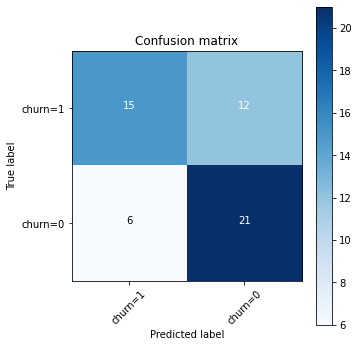

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [36]:
precision_1,precision_0 = 15/27,21/27
print('Precision_1 = {:.2f}'.format(precision_1))
print('Precision_0 = {:.2f}'.format(precision_0))

Precision_1 = 0.56
Precision_0 = 0.78


In [37]:
recall_1,recall_0 = 15/21, 21/33
print('Recall_1 = {:.2f}'.format(recall_1))
print('Recall_0 = {:.2f}'.format(recall_0))

Recall_1 = 0.71
Recall_0 = 0.64
